In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

import torch.nn.functional as F
from src.utils import *
from src.datatype import *

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

c:\Users\noe\anaconda3\envs\torchIO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

In [5]:
dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

## Play with rendering

In [69]:
def trace_ray(
    volume: torch.Tensor,
    source: torch.Tensor,
    direction: torch.Tensor,
    num_samples: int
) -> torch.Tensor:
    """
    Trace a ray through a 3D volume and sample intensity values.

    Args:
        volume (torch.Tensor): 3D volume of shape (D, H, W).
        source (torch.Tensor): Starting point of the ray (x, y, z).
        direction (torch.Tensor): Direction of the ray (dx, dy, dz).
        num_samples (int): Number of samples to take along the ray.

    Returns:
        torch.Tensor: Sampled intensity values along the ray.
    """
    # Get volume dimensions      

    volume = (volume - volume.min()) / (volume.max() - volume.min())
    D, H, W = volume.shape

    # Normalize direction
    direction = torch.tensor(direction, dtype=torch.float32)
    direction = direction / direction.norm()

    # Compute points along the ray
    source = torch.tensor(source, dtype=torch.float32)
    steps = torch.arange(0, num_samples, dtype=torch.float32).unsqueeze(1)
    points = source + steps * direction  # (num_samples, 3)

    # Normalize to [-1, 1] for grid_sample
    grid = torch.empty_like(points)
    grid[:, 0] = 2 * (points[:, 2] / max(D - 1, 1)) - 1  # z → x
    grid[:, 1] = 2 * (points[:, 1] / max(H - 1, 1)) - 1  # y → y
    grid[:, 2] = 2 * (points[:, 0] / max(W - 1, 1)) - 1  # x → z
    grid = grid.view(1, num_samples, 1, 1, 3)  # (N, D_out, H_out, W_out, 3)

    # Prepare volume for grid_sample: (N, C, D, H, W)
    volume = volume.unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)

    # Sample
    ray_values = F.grid_sample(volume, grid, align_corners=True, mode='bilinear').squeeze()

    return ray_values

In [82]:
def trace_rays(volume, sources, direction, num_samples):
    """
    Trace multiple rays from a set of sources in the same direction.

    Args:
        volume (torch.Tensor): (D, H, W)
        sources (torch.Tensor): (N, 3) source points
        direction (tuple or torch.Tensor): (dx, dy, dz)
        num_samples (int): Number of steps per ray

    Returns:
        torch.Tensor: (N, num_samples) intensity values for each ray
    """
    all_profiles = []
    for src in sources:
        profile = trace_ray(volume, src, direction, num_samples)
        all_profiles.append(profile)
    return torch.stack(all_profiles)  # (N, num_samples)

def compute_value(ray):
    """
    Compute the value of a ray using the trapezoidal rule.

    Args:
        ray (torch.Tensor): Intensity values along the ray.

    Returns:
        float: Computed value.
    """
    # Compute the value using the trapezoidal rule
    return torch.trapz(ray, dim=0).item() 


C:\Users\noe\AppData\Local\Temp\ipykernel_23664\1835963857.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



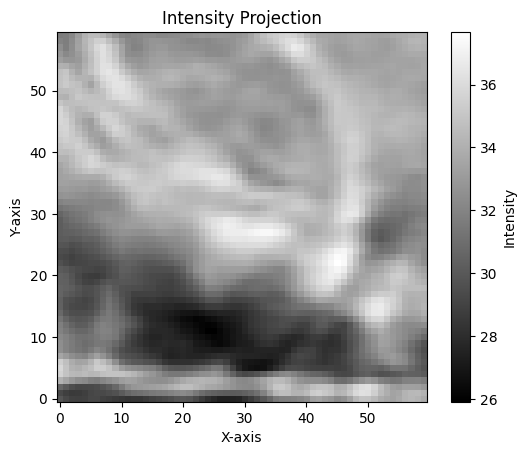

In [93]:
sample = dataset[0]

volume = sample['image'].squeeze(0)

direction = (0, 0, 1)
x_center, y_center, z_center = 80, 20, 0
x_range = range(x_center - 10, x_center + 50)
y_range = range(y_center - 20, y_center + 40)

sources = torch.tensor(
    [[x, y, z_center] for x in x_range for y in y_range], dtype=torch.float32
)

profiles = trace_rays(volume, sources, direction, num_samples=300)

# Compute the value of each ray
values = [compute_value(ray) for ray in profiles]

# Reshape values to match the grid size
values_grid = torch.tensor(values).view(len(x_range), len(y_range))

plt.imshow(values_grid.numpy(), cmap='gray', origin='lower')
plt.title("Intensity Projection")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Intensity")
plt.show()

In [75]:
big_ray = trace_ray(volume, source, direction, num_samples)
for sources in [[0,0,i] for i in range(0, 100, 10)]:

    ray_values = trace_ray(volume, source, direction, num_samples)
    big_ray = torch.cat((big_ray, [ray_values]), dim=0)
    

plt.plot(big_ray.cpu().numpy())
plt.title("Intensity Profile Along Ray")
plt.xlabel("Step")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()

C:\Users\noe\AppData\Local\Temp\ipykernel_23664\1835963857.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_23664\1835963857.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



TypeError: expected Tensor as element 1 in argument 0, but got list